## Intro

### Abstract

Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset.

### Data Set Information

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: `((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))`

Prediction task is to determine whether a person makes over 50K a year.

## Initialization

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
CURRENT_DIR = os.path.abspath(os.path.dirname(__name__))
DATA_DIR = os.path.join(CURRENT_DIR, 'data')

TRAIN_DATA_FILE = os.path.join(DATA_DIR, 'adult.data')
TEST_DATA_FILE = os.path.join(DATA_DIR, 'adult.test')

In [3]:
from collections import OrderedDict

data_types = OrderedDict([
    ("age", "int"),
    ("workclass", "category"),
    ("final_weight", "int"),  # originally it was called fnlwgt
    ("education", "category"),
    ("education_num", "int"),
    ("marital_status", "category"),
    ("occupation", "category"),
    ("relationship", "category"),
    ("race", "category"),
    ("sex", "category"),
    ("capital_gain", "float"),  # required because of NaN values
    ("capital_loss", "int"),
    ("hours_per_week", "int"),
    ("native_country", "category"),
    ("income_class", "category"),
])
target_column = "income_class"

## Columns to remove

It looks like column `final_weight` (a.k.a `fnlwgt`) tells the proportion of the population that has the same set of features. Basically, every row in the original table was de-duplicated and final weight stores number of rows that had excatly the same value. We definitely don't need to use this column during the model training.

## Helthcheck

Helth check allows us to make sure that loaded dataset looks fine and there is no obvious problems with the data

In [4]:
def read_dataset(path):
    data = pd.read_csv(
        path,
        names=data_types,
        index_col=None,
        dtype=data_types,
        comment='|',  # test dataset has one comment in it
    )
    data = data.drop('final_weight', axis=1)
    return data

In [5]:
train_data = read_dataset(TRAIN_DATA_FILE)
train_data.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0,40,Cuba,<=50K


In [6]:
train_data.tail()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0,38,United-States,<=50K
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0,40,United-States,>50K
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0,40,United-States,<=50K
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0.0,0,20,United-States,<=50K
32560,52,Self-emp-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024.0,0,40,United-States,>50K


In [7]:
test_data = read_dataset(TEST_DATA_FILE)
test_data.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0,40,United-States,<=50K.
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0,50,United-States,<=50K.
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0,40,United-States,>50K.
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0,40,United-States,>50K.
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0.0,0,30,United-States,<=50K.


In [8]:
test_data.tail()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
16276,39,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0,36,United-States,<=50K.
16277,64,?,HS-grad,9,Widowed,?,Other-relative,Black,Male,0.0,0,40,United-States,<=50K.
16278,38,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0,50,United-States,<=50K.
16279,44,Private,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0,40,United-States,<=50K.
16280,35,Self-emp-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0,60,United-States,>50K.


It looks like the `income_class` column in the test data has extra dot at the end. We will need to clean it during data processing

In [9]:
print("Train shape: {}".format(train_data.shape))
print("Test shape: {}".format(test_data.shape))

Train shape: (32561, 14)
Test shape: (16281, 14)


In [10]:
train_data.shape[0] + test_data.shape[0]

48842

Each dataset has 14 predictor columns and training dataset has one extra column with labeled class that we need to predict. Total number of samples also matches number of instances specified in the `Dataset Description.odt` file.

## First look into the available values

In [11]:
# We combine two datasets in order to generalize issues observed in the data
data = pd.concat([test_data, train_data])
data.describe(include='all')

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
count,48842.000000,48842,48842,48842.000000,48842,48842,48842,48842,48842,48842.000000,48842.000000,48842.000000,48842,48842
unique,NaN,9,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,4
top,NaN,Private,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,33906,15784,NaN,22379,6172,19716,41762,32650,NaN,NaN,NaN,43832,24720
mean,38.643585,NaN,NaN,10.078089,NaN,NaN,NaN,NaN,NaN,1079.067626,87.502314,40.422382,NaN,NaN
std,13.710510,NaN,NaN,2.570973,NaN,NaN,NaN,NaN,NaN,7452.019058,403.004552,12.391444,NaN,NaN
min,17.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


### To many income classes

First of all, we can see that the `income_class` column has 4 unique classes, but we expect to have only two.

In [12]:
data.income_class.value_counts(dropna=False)

 <=50K     24720
 <=50K.    12435
 >50K       7841
 >50K.      3846
Name: income_class, dtype: int64

In [13]:
test_data.income_class.value_counts(dropna=False)

 <=50K.    12435
 >50K.      3846
Name: income_class, dtype: int64

In [14]:
train_data.income_class.value_counts(dropna=False)

 <=50K    24720
 >50K      7841
Name: income_class, dtype: int64

Test data has extra dot at the end of the class name. It has to be fixed in the final data cleaning procedure.

### Extra category

In [15]:
data.occupation.value_counts(dropna=False).to_frame()

,occupation
Prof-specialty,6172
Craft-repair,6112
Exec-managerial,6086
Adm-clerical,5611
Sales,5504
Other-service,4923
Machine-op-inspct,3022
?,2809
Transport-moving,2355
Handlers-cleaners,2072


In [16]:
data.workclass.value_counts(dropna=False).to_frame()

,workclass
Private,33906
Self-emp-not-inc,3862
Local-gov,3136
?,2799
State-gov,1981
Self-emp-inc,1695
Federal-gov,1432
Without-pay,21
Never-worked,10


We can confirm that those are the only columns that have value equal to `?`.

In [17]:
(data == ' ?').sum(axis=0)

age                  0
workclass         2799
education            0
education_num        0
marital_status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     857
income_class         0
dtype: int64

### Space in the values

Also, from the close look it gets obvious that there are spaces in the columns that has to be cleaned during the data parsing state. It can be fixed with extra `skipinitialspace` argument in the `read_csv` function.

In [18]:
data.workclass.cat.categories

Index([' ?', ' Federal-gov', ' Local-gov', ' Never-worked', ' Private',
       ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay'],
      dtype='object')

### Suspicios values with 9s

Two columns have max value with all 9s in them. It's common that people use values with all 9s in order to mark NaN values in columns with numerical values.

In [19]:
data.capital_gain.value_counts(dropna=False).head(10)

0.0        44807
15024.0      513
7688.0       410
7298.0       364
99999.0      244
3103.0       152
5178.0       146
5013.0       117
4386.0       108
8614.0        82
Name: capital_gain, dtype: int64

In [20]:
import heapq
heapq.nlargest(10, data.capital_gain.unique())

[99999.0,
 41310.0,
 34095.0,
 27828.0,
 25236.0,
 25124.0,
 22040.0,
 20051.0,
 18481.0,
 15831.0]

There are no values even close to `99999` in the `capital_gain` columns, which quite likely means that this value identifies NaN for this column

In [21]:
import heapq
heapq.nlargest(10, data.hours_per_week.unique())

[99, 98, 97, 96, 95, 94, 92, 91, 90, 89]

In case of `hours_per_week` we can see that there are some unique values that close to 99

In [22]:
hours_per_week_counts = data.hours_per_week.value_counts()
largest_hours_per_week = heapq.nlargest(10, data.hours_per_week.unique())
hours_per_week_counts[hours_per_week_counts.index.isin(largest_hours_per_week)]

99    137
90     42
98     14
96      9
91      3
89      3
92      3
97      2
95      2
94      1
Name: hours_per_week, dtype: int64

If we check countwise it's clear that 99 is unusually large compare to other values. It also could be that 99 means 99+ hours and long tail might fit into this category.

### Check duplicates

In [23]:
n_samples_before = train_data.shape[0]
n_samples_after = train_data.drop_duplicates().shape[0]

print(n_samples_before)
print(n_samples_after)
print("Duplicates removed: {:.2%}".format((n_samples_before - n_samples_after) / n_samples_before))

32561
29096
Duplicates removed: 10.64%


After removing final weight column we get 10% of duplicates in the training data. We need to remove it before continuing our analysis in order to avoid biases.

## Apply first cleaning steps

These steps allow us to address biggest issues that we found so far. Without this fixes it will be harder to do data analysis.

In [24]:
def clean_dataset(data):
    # Test dataset has dot at the end, we remove it in order
    # to unify names between training and test datasets.
    data['income_class'] = data.income_class.str.rstrip('.').astype('category')
    
    # Remove final weight column since there is no use
    # for it during the classification.
    data = data.drop('final_weight', axis=1)
    
    # Duplicates might create biases during the analysis and
    # during prediction stage they might give over-optimistic
    # (or pessimistic) results.
    data = data.drop_duplicates()

    return data

def read_dataset(path):
    return pd.read_csv(
        path,
        names=data_types,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={
            'capital_gain': 99999,
            'workclass': '?',
            'native_country': '?',
            'occupation': '?',
        },
        dtype=data_types,
    )

train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))

# We will use data as a shortcut to the train_data. We will avoid
# using test data during the analysis in order to make sure that
# there won't be any information leakage from the test data
data = train_data

In [25]:
categorical_columns = (data
    .select_dtypes(['category', 'object'])
    .drop(target_column, axis=1)
    .columns)

## Checking data distributions

### Dominant value in capital gain column

A few columns have quite dominant values in them, meaning that they occupy quite large percentage of the data

In [26]:
(data.capital_gain == 0)

0        False
1         True
2         True
3         True
4         True
         ...  
32554     True
32555     True
32556     True
32558     True
32560    False
Name: capital_gain, Length: 29096, dtype: bool

### Checking counts per category

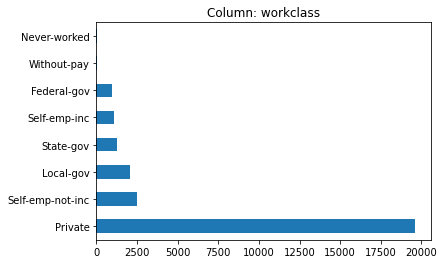

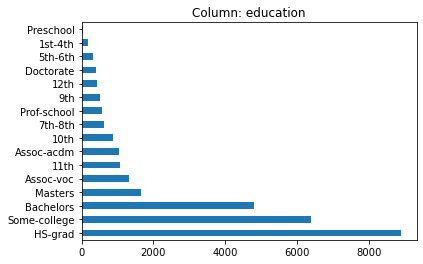

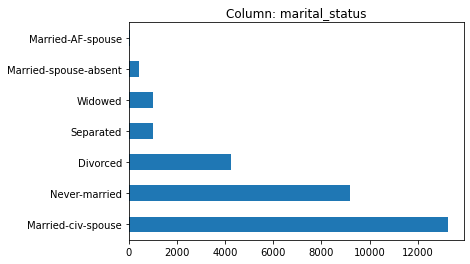

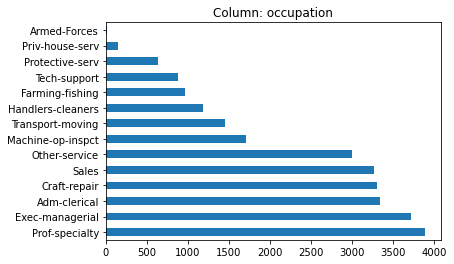

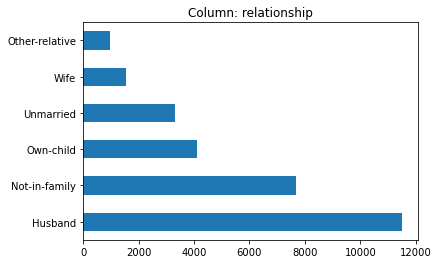

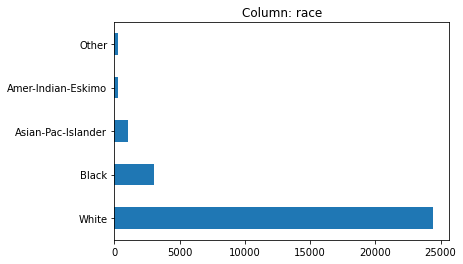

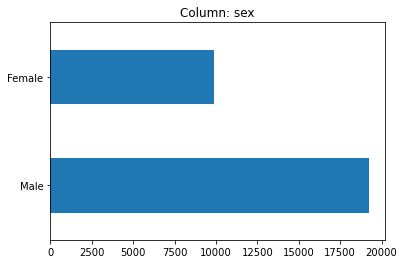

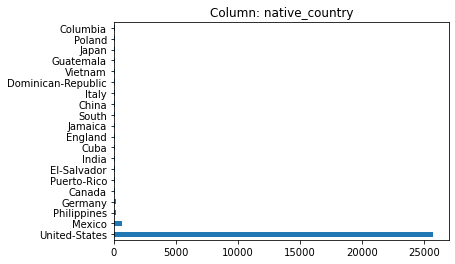

In [27]:
for colname in categorical_columns:
    plt.title('Column: ' + colname)

    (data[colname]
         .value_counts()
         .head(20)
         .plot(kind='barh', color=colors[0]))

    plt.show()

Observations:

1. Quite large number of the `race=White` values

2. Quite large number of the `workclass=Private` values.

3. Quite large number of the `natice_country=United-States` values. This variable can be either ignore or replaced. with binary variable like `from_united_states` that will be equal to `True` if person from united states, and `False` otherwise.

### Checking histograms for numerical columns

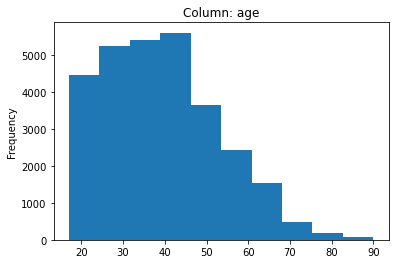

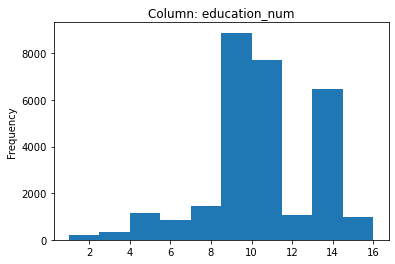

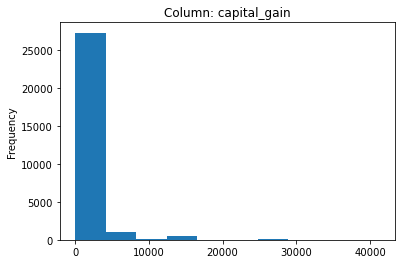

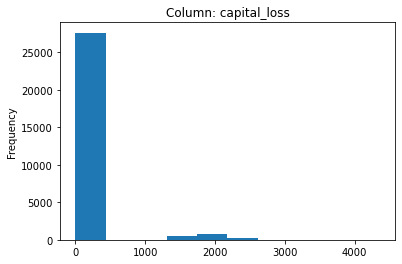

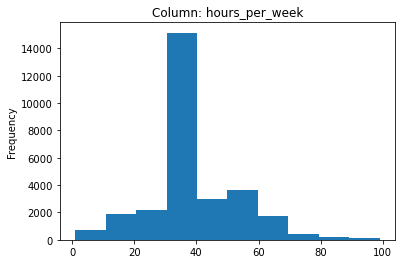

In [28]:
for colname, column_series in data._get_numeric_data().iteritems():
    plt.title('Column: ' + colname)
    column_series.plot(kind='hist')
    plt.show()

Observations:
    
1. The `hours_per_week` has large spike where value equal to `40` which makes sense since it's the most common number of working hours per week for average person.

2. The `capital_loss` and `capital_gain` variables have large spike where value equal to zero. It's typicall that average person doesn't have additional incomes. It makes sense to see distribution without zero values for these columns.

3. The `education_num` column has two spikes. First spike around the number of years that it takes to complete school for the average person and the second one for university.

### Correlation between numerical columns

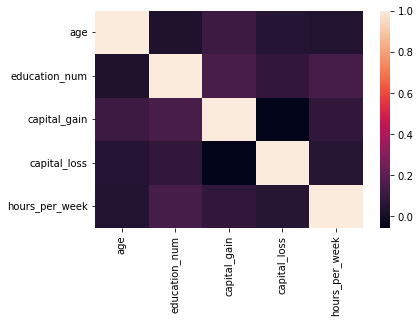

In [29]:
corr = data._get_numeric_data().corr()
sns.heatmap(
    corr, 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values
);

Numerical feautres have very low correlation.

## Split feature effects per category

### Numerical columns

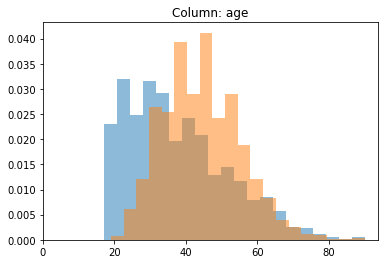

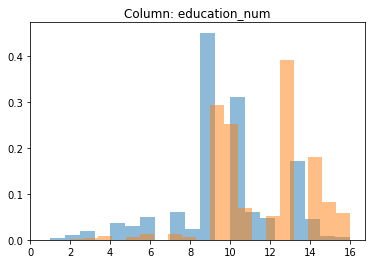

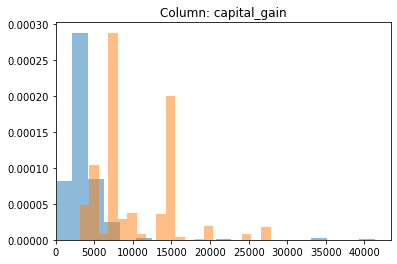

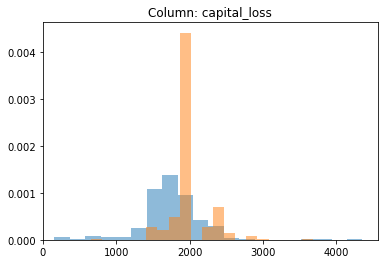

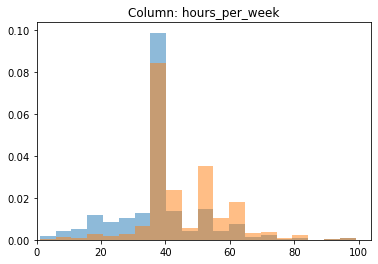

In [30]:
for colname in data._get_numeric_data().columns:
    df = data
    
    if colname in ('capital_gain', 'capital_loss'):
        # These columns have large number of zeros and it will skew
        # distribution. In order to avoid this issue we cut zero values
        # from the distribution.
        df = df[(data[colname] != 0) & ~data[colname].isnull()]
        
    low_income = df.loc[df[target_column] == '<=50K', colname]
    high_income = df.loc[df[target_column] == '>50K', colname]
    
    plt.title('Column: ' + colname)
    plt.hist(low_income, label='<=50K', bins=20, density=True, alpha=0.5)
    plt.hist(high_income, label='>50K', bins=20, density=True, alpha=0.5)
    
    xmin, xmax = plt.xlim()
    plt.xlim(0, xmax)
    plt.show()

Observations:

1. The older the person the more likely it will have higher income

2. The more years of education person had the more likely it will have higher income.

3. The more person works the more income this person has.

### Categorical columns

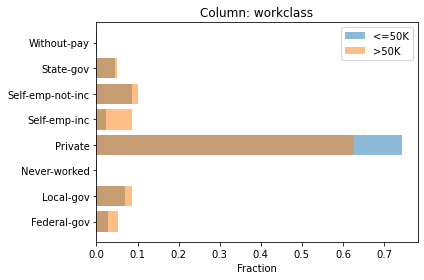

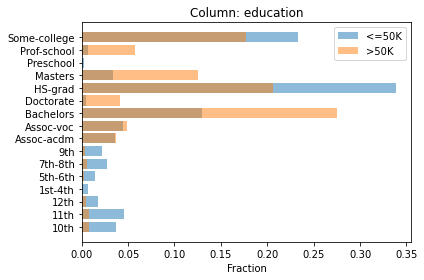

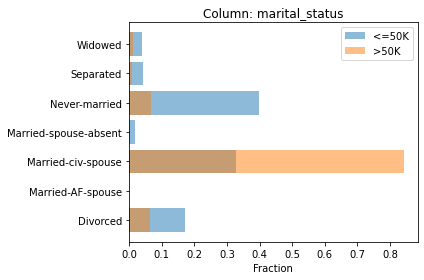

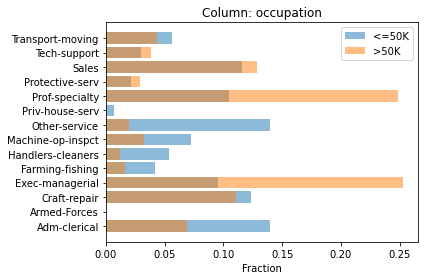

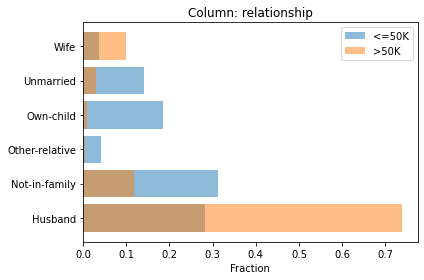

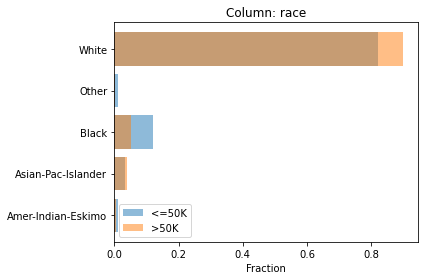

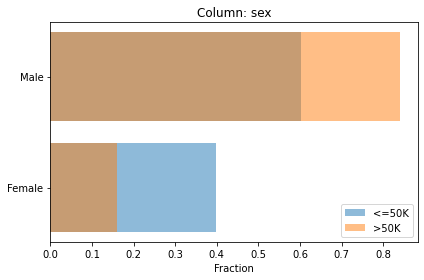

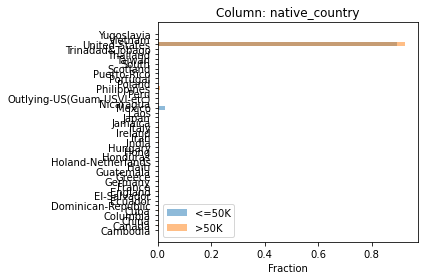

In [32]:
for colname in categorical_columns:
    low_income = data.loc[df[target_column] == '<=50K', colname]
    high_income = data.loc[df[target_column] == '>50K', colname]
    
    low_income_stats = low_income.value_counts()
    high_income_stats = high_income.value_counts()
    
    low_bar = plt.barh(
        low_income_stats.index.codes,
        low_income_stats.values / low_income_stats.values.sum(),
        alpha=0.5,
    )
    high_bar = plt.barh(
        high_income_stats.index.codes,
        high_income_stats.values / high_income_stats.values.sum(),
        alpha=0.5,
    )
    
    plt.title('Column: ' + colname)
    plt.xlabel('Fraction')
    plt.legend([low_bar, high_bar], ['<=50K', '>50K'])
    plt.yticks(np.arange(len(high_income_stats)), high_income_stats.index.categories)
    plt.tight_layout()
    plt.show()